# MNIST Classifier with HELayers (HE) - Secure Aggregation in IBM FL

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL)](#intro)
- [How deos IBM FL work with HE?](#HE-FL)
- [Digit Recognition](#mnist)
- [Parties](#Parties)
    - [Party Configuration](#Party-Configuration)
    - [Party Setup](#Party-Setup)
- [Register All Parties Before Starting Training](#Register-All-Parties-Before-Starting-Training)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Please install the `matplotlib` package for your conda environment. 

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/notebooks/`, where project_path is the directory where the IBMFL repository was cloned.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL) <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

In this Notebook we use [IBM FL](https://github.com/IBM/federated-learning-lib) together with Homomorphic Encryption to have multiple parties train a classifier to recognise handwritten digits in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). 

For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 2 parties, but depending on your resources you may use more parties.

<img style="display=block; margin:auto" src="../images/FL_Network.png" width="720"/>
<p style="text-align: center">Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></p>

## How does IBM FL work with HE? <a name="HE-FL"></a>

IBM FL uses the *[Cheon-Kim-Kim-Song (CKKS) scheme](https://eprint.iacr.org/2016/421.pdf)* for Homomorphic Encryption. HE functionalities are implemented using *[IBM HElayers software development kit (SDK)](https://github.com/IBM/helayers)*, and in particular, its *[PyHElayers](https://github.com/IBM/helayers#pyhelayers-python-package)* Python package. You can install `pyhelayers` in your conda environment by running `pip install pyhelayers`. Note that `pyhelayers` is currently supported only on Linux (x86 and IBM Z).

<img style="display=block; margin:auto" src="../images/ibmfl_helayer.png" width="512"/>
<p style="text-align: center">IBM FL library integrated with HELayers </p>

After enabling IBM FL with HE, parties do not send their model updates in plaintext. Each party sends an encrypted model update and the aggregation is performed under encryption. (See the figure below.) 


![SegmentLocal](../images/FL_FHE_v3.gif "segment")
<p style="text-align: center">FL Training with HE</a></p>

## Digit Recognition <a name="mnist"></a>



<img style="display=block; margin:auto" src="../images/MnistExamples.png" width="512"/>
<p style="text-align: center">Image Source: Josef Steppan / CC BY-SA <a href="https://creativecommons.org/licenses/by-sa/4.0">Wikimedia Commons</a></p>

The problem at hand is to recognize digits from these tens of thousands of handwritten images. 

### Getting things ready
We begin by setting the number of parties that will participate in the federated learning run and splitting up the data among them.

In [1]:
import sys
party_id = 0

sys.path.append('../..')
import os
os.chdir("../..")

dataset = 'mnist'

## Parties

Each party holds its own dataset that is kept to itself and used to answer queries received from the aggregator. Because each party may have stored data in different formats, FL offers an abstraction called Data Handler. This module allows for custom implementations to retrieve the data from each of the participating parties. A local training handler sits at each party to control the local training happening at the party side. 

<img style="display=block; margin:auto" src="../images/FHE_stacks.png" width="680"/>
<p style="text-align: center">Aggregator and Party side configurations</a></p>

### Party Configuration

**Note**: in a typical FL setting, the parties may have very different configurations from each other. However, in this simplified example, the config does not differ much across parties. So, we first setup the configuration common to both parties, in the next cell. We discuss the parameters that are specific to each, in subsequent cells.

### Party Setup
In the following cell, we setup configurations for parties, including network-level details, hyperparameters as well as the model specifications. Please note that if you are running this notebook in distributed environment on separate nodes then you need to split the data locally and obtain the model h5 generated by the Aggregator.

#### Building Blocks in Party Configuration:

Now we configure party specific configurations in the `get_party_config` method, which specifies model related configurations as well as other parameters necessary for the federated learning setup. The model related configurations are identical to those generated (yaml files) during the terminal run.

Once these are done, we invoke them for each party, in the subsequent cell.

- `aggregator`: IP and port at which the Aggregator is running, so the party may connect to it

- `data`: information needed to initiate a data handler class; includes a given data path, a data handler class name, and a data handler file location

- `model`: details about the model, including name, the model class file location, i.e., path, and the given model specification path, i.e., spec. In this example, we use the Tensorflow FL Model class, as indicated under the spec

- `local_training`: handles the train and eval commands, also initializes data, environment and models.
    + 'name': 'CryptoLocalTrainingHandler', -> This makes sure that the local training handler with HE is invoked (currently, this is the only local training handler with HE that is supported)
    + 'path': 'ibmfl.party.training.crypto_fedavg_local_training_handler', -> The path to the previous item
    + 'info': inside this field, we specify the crypto options including:
        - 'crypto'
            + name: specify the crypto system (Use `CryptoFHE` for Homomorphic Encryption. Other crypto systems may be added at a later stage.)
            + path: the path to the previous item
            + key_manager:
                - name: specify the key manager type (This is fixed to `LocalDiskKeyManager` for now. More key management protocols may be added at a later stage.)
                - path: the path to the previous item (This is fized to `ibmfl.crypto.keys_mng.crypto_key_mng_dsk` for now.)
                - key_mgr_info: specify the paths for the private key file and public key context file


- `protocol_handler`: party protocol handler communicates with the Aggregator bridging between Aggregator and local training handler. 
    - 'name': 'PartyProtocolHandler',
    - 'path': 'ibmfl.party.party_protocol_handler', -> The path to the previous item

**Note**: in a typical FL setting, the parties may have very different configurations from each other. However, in this simplified example, the config does not differ much across parties. Also, as of this release all parties registered with the aggregator participate in the training. Dynamically letting registered parties to skip training in certain rounds will be supported in subsequent versions.

In [2]:
ctx_file = os.path.join(os.getcwd(), 'notebooks/fhe.context')
key_file = os.path.join(os.getcwd(), 'notebooks/fhe.key')
def get_party_config(party_id):
    party_config = {
        'aggregator': {
            'ip': '127.0.0.1',
            'port': 5000
        },
        'connection': {
            'info': {
                'ip': '127.0.0.1',
                'port': 8085 + party_id
            },
            'name': 'FlaskConnection',
            'path': 'ibmfl.connection.flask_connection',
            'sync': False
        },
        'data': {
            'info': {
                'npz_file': 'examples/data/mnist/random/data_party'+ str(party_id) +'.npz'
            },
            'name': 'MnistTFDataHandler',
            'path': 'ibmfl.util.data_handlers.mnist_keras_data_handler'
        },
        'local_training': {
            'name': 'CryptoLocalTrainingHandler',
            'path': 'ibmfl.party.training.crypto_local_training_handler',
            'info': {
                'crypto': {
                    'name': 'CryptoFHE',
                    'path': 'ibmfl.crypto.helayer.fhe',
                    'key_manager': {
                        'name': 'LocalDiskKeyManager',
                        'path': 'ibmfl.crypto.keys_mng.crypto_key_mng_dsk',
                        'key_mgr_info': {
                            'files': {
                                'context': ctx_file,
                                'key': key_file
                            }
                        }
                    }
                }
            }
        },
        'model': {
            'name': 'TensorFlowFLModel',
            'path': 'ibmfl.model.tensorflow_fl_model',
            'spec': {
                'model_definition': 'examples/configs/tf_classifier',
                'model_name': 'tf-cnn'
            }
        },
        'protocol_handler': {
            'name': 'PartyProtocolHandler',
            'path': 'ibmfl.party.party_protocol_handler'
        }
    }
    return party_config


### Running the Party

Now, we invoke the `get_party_config` function to setup party and `start()` it.

Finally, we register the party with the Aggregator.

In [3]:
from ibmfl.party.party import Party
import tensorflow as tf

party_config = get_party_config(party_id)
party = Party(config_dict=party_config)
party.start()
party.register_party()
party.proto_handler.is_private = False  ## allows sharing of metrics with aggregator

2022-11-18 20:18:13.203 INFO   numexpr.utils :: Note: NumExpr detected 30 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-11-18 20:18:13.204 INFO   numexpr.utils :: NumExpr defaulting to 8 threads.


2022-11-18 20:18:13,958 | 1.0.7 | INFO | ibmfl.util.config                             | Getting Aggregator details from arguments.
2022-11-18 20:18:14,164 | 1.0.7 | INFO | ibmfl.util.config                             | No metrics recorder config provided for this setup.
2022-11-18 20:18:14,334 | 1.0.7 | INFO | ibmfl.util.config                             | No metrics config provided for this setup.
2022-11-18 20:18:14,335 | 1.0.7 | INFO | ibmfl.util.config                             | No evidencia recordeer config provided for this setup.
2022-11-18 20:18:14,335 | 1.0.7 | INFO | ibmfl.util.data_handlers.mnist_keras_data_handler | Loaded training data from examples/data/mnist/random/data_party0.npz


2022-11-18 20:18:14.373055: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-18 20:18:14.373283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 20:18:14.375641: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-11-18 20:18:14,642 | 1.0.7 | INFO | ibmfl.connection.flask_connection             | RestSender initialized
2022-11-18 20:18:14,644 | 1.0.7 | INFO | ibmfl.crypto.crypto_library                   | Initializing a key manager
2022-11-18 20:18:14,645 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Initializing keys
2022-11-18 20:18:14,646 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | Initializing a FHE Cipher
2022-11-18 20:18:14,674 | 1.0.7 | INFO | ibmfl.crypto.helayer.fhe                      | No flag for privacy of fusion weights in config. Setting to default value of False.
2022-11-18 20:18:14,676 | 1.0.7 | INFO | ibmfl.connection.flask_connection             | Receiver Initialized
2022-11-18 20:18:14,677 | 1.0.7 | INFO | ibmfl.connection.flask_connection             | Initializing Flask application
2022-11-18 20:18:14,680 | 1.0.7 | INFO | ibmfl.party.party                             | Party initialization successful
2022-11-18 20:18:14,681 | 

2022-11-18 20:18:49.128534: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-18 20:18:49.129002: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300080000 Hz


4/4 [==============================] - 1s 166ms/step - loss: 2.0416 - accuracy: 0.3003
Epoch 2/5
4/4 [==============================] - 1s 136ms/step - loss: 0.9484 - accuracy: 0.7662
Epoch 3/5
4/4 [==============================] - 1s 143ms/step - loss: 0.5037 - accuracy: 0.8662
Epoch 4/5
4/4 [==============================] - 1s 133ms/step - loss: 0.3286 - accuracy: 0.9135
Epoch 5/5
4/4 [==============================] - 0s 103ms/step - loss: 0.2459 - accuracy: 0.9217
2022-11-18 20:18:52,612 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Local training done, start to encrypt model update...
2022-11-18 20:18:52,615 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Encrypting - <class 'ibmfl.crypto.helayer.fhe.CryptoFHE'>
2022-11-18 20:18:55,384 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Encryption done.
2022-11-18 20:18:58,847 | 1.0.7 | INFO | ibmfl.util.fl_metrics                         | reshaping y_pred
2022-11-

Epoch 1/5
4/4 [==============================] - 0s 137ms/step - loss: 0.1148 - accuracy: 0.9700
Epoch 2/5
4/4 [==============================] - 1s 145ms/step - loss: 0.0660 - accuracy: 0.9880
Epoch 3/5
4/4 [==============================] - 1s 133ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 1s 125ms/step - loss: 0.0223 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 1s 128ms/step - loss: 0.0191 - accuracy: 1.0000
2022-11-18 20:19:41,702 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Local training done, start to encrypt model update...
2022-11-18 20:19:41,705 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Encrypting - <class 'ibmfl.crypto.helayer.fhe.CryptoFHE'>
2022-11-18 20:19:43,566 | 1.0.7 | INFO | ibmfl.party.training.crypto_local_training_handler | Encryption done.
2022-11-18 20:19:46,370 | 1.0.7 | INFO | ibmfl.util.fl_metrics                         | reshaping y_pre

## Register All Parties Before Starting Training

Now we have started and registered this Party. Next, we will start and register rest of the parties. Once all the Parties have registered we will go back to the Aggregator's notebook to start training.

## Visualize Results

Here we plot the summary graphs from each party's training.

In [4]:
import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
_, (X_test, Y_test) = mnist.load_data()
X_test = X_test[..., tf.newaxis].astype('float32')

Using TensorFlow backend.


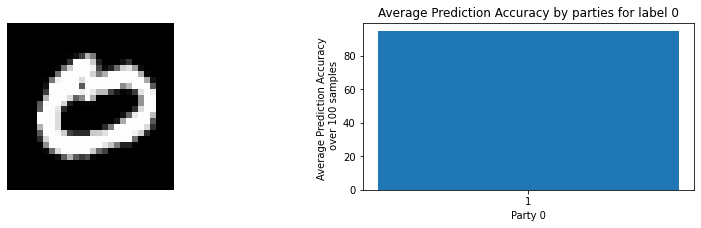

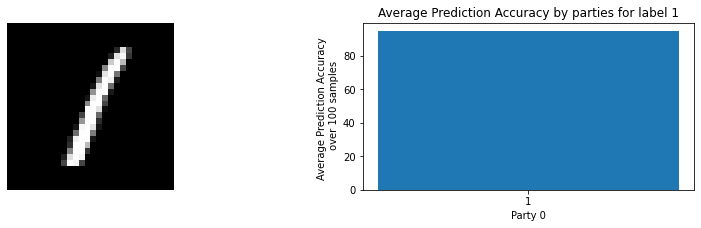

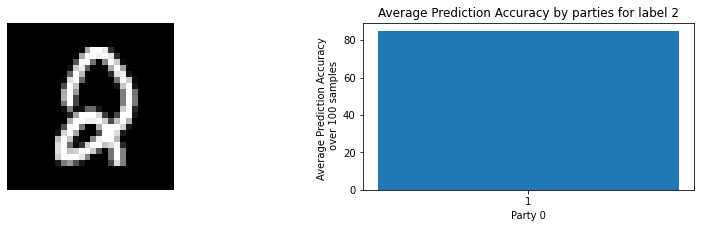

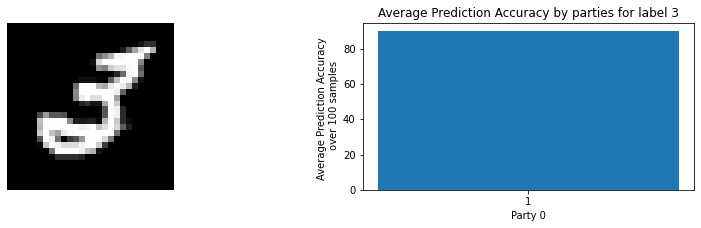

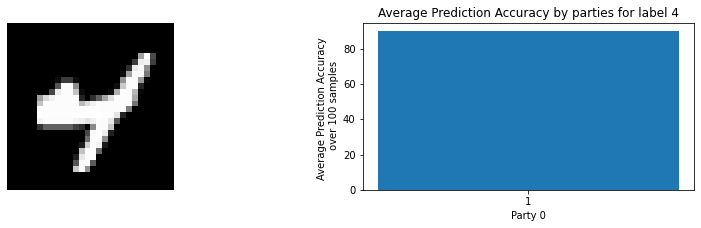

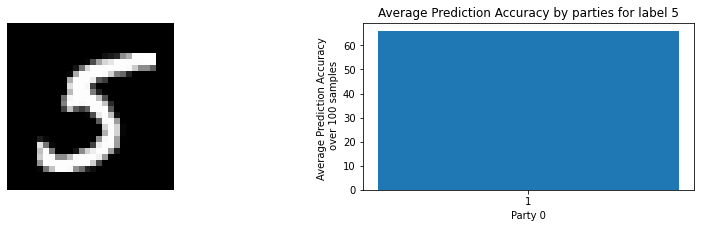

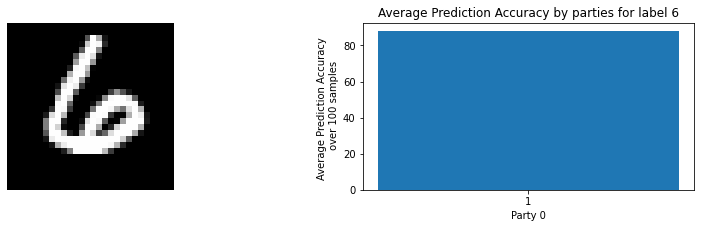

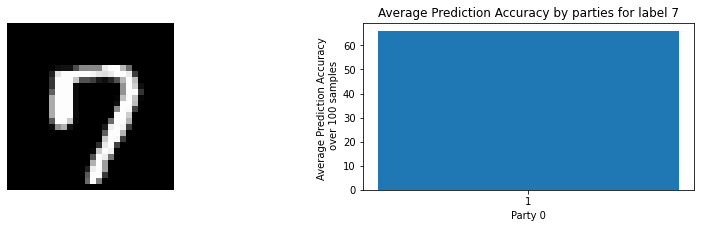

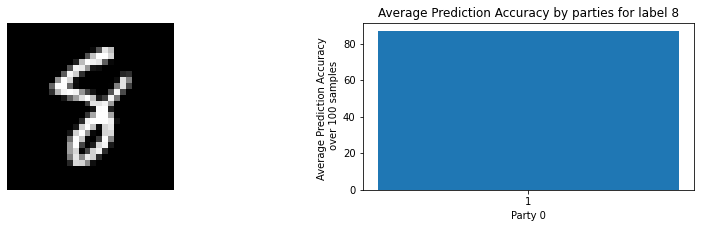

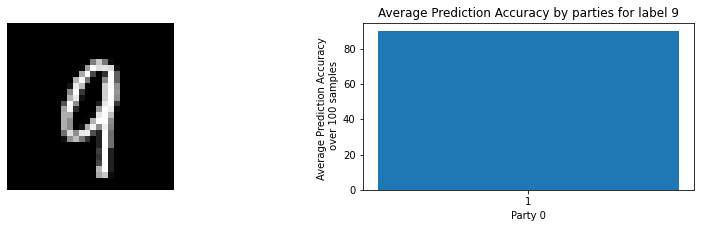

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import keras
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
sample_count = 100
num_parties = 1
for i in range(10):
   test_filter = np.where(Y_test == i)
   X_test1, Y_test1 = X_test[test_filter], Y_test[test_filter]
   #labels, counts = np.unique(Y_test1, return_counts=True)
   np.random.seed(123)
   rand_v = np.random.randint(0, X_test1.shape[0],sample_count)
   test_digits = X_test1[rand_v]
   test_labels = Y_test1[rand_v]
   labels, counts = np.unique(test_labels, return_counts=True)
   #print('Original lable', labels)
   acc_list = np.array([])
   y_true = np.full(sample_count, i)

       
   y_pred = np.array([])
   for i_samples in range(sample_count):
      pred = party.fl_model.predict(test_digits[i_samples].reshape(1, 28, 28, 1))
      y_pred = np.append(y_pred, pred.argmax())
   acc = accuracy_score(y_true, y_pred) * 100
   #print('y prediction',y_pred)
   #print('y true',y_true)
   #print('accuracy',acc)
   acc_list = np.append(acc_list,acc)

   ind = np.arange(num_parties) 
   fig2 = plt.figure(constrained_layout=True,figsize=(10,10))
   fig2.tight_layout()
   spec2 = gridspec.GridSpec(ncols=6, nrows=4, figure=fig2) 
   f2_ax1 = fig2.add_subplot(spec2[0:1, 0:2])
   f2_ax1.imshow(test_digits[0], cmap='gray')
   plt.axis('off')
   f2_ax2 = fig2.add_subplot(spec2[0:1, 3:])
   labels = [(i+1) for i in range(num_parties)] 
   
   x = np.arange(num_parties)
  

   rects1 = f2_ax2.bar(x, acc_list, width=0.3)
   # Add some text for labels, title and custom x-axis tick labels, etc.
   f2_ax2.set_xlabel('Party ' + str(party_id))
   f2_ax2.set_ylabel('Average Prediction Accuracy \n over '+str(sample_count)+' samples')
   f2_ax2.set_title('Average Prediction Accuracy by parties for label '+str(i))
   f2_ax2.set_xticks(x)
   f2_ax2.set_xticklabels(labels)

## Shut Down

Invoke the `stop()` method on each of the network participants to terminate the service.

In [ ]:
party.stop()